In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from itertools import combinations
from collections import Counter
from zipfile import ZipFile
import os
from networkx.algorithms.community import girvan_newman
import json
import requests
import re
import matplotlib.patches as mpatches
import itertools
import matplotlib.cm as cm
from pprint import pprint
import math
import pyLDAvis.gensim
import pickle 
import pyLDAvis
from tqdm import tqdm
import gensim
from gensim import corpora
from wordcloud import WordCloud
import community.community_louvain as cl
import community
from sklearn.cluster import SpectralClustering

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
pd.options.mode.chained_assignment = None  # default='warn'

[nltk_data] Downloading package wordnet to /Users/ellen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ellen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [148]:
# Reusable variables
seed = 33
d_color = "#4152ec"
colors = ['#292929', '#768695', d_color, '#50dcff', '#ffa30e', '#ffe72f', '#f43131', '#ff9ad2', '#2ca02c', '#a8ee72', '#795133', '#c98d66']

In [149]:
# used csv files, linking it with their source zip files
csv_to_zip_source = {
    "Netflix_Dataset_Movie.csv": "zip_sources/Netflix_Dataset_Movie.csv.zip",
    "Netflix_Dataset_Rating.csv": "zip_sources/Netflix_Dataset_Rating.csv.zip",
    "tmdb_5000_credits.csv": "zip_sources/tmdb.zip",
    "tmdb_5000_movies.csv": "zip_sources/tmdb.zip"
}

csv_file_names = list(csv_to_zip_source.keys())

# common data directory path
data_dir = "./data"

# if directory does not exist, create it
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

# check if all .csv can be found in data directory, if not we extract it from corresponding zip source
for csv_file_name in csv_file_names:
    if not os.path.exists(f"{data_dir}/{csv_file_name}"):
        # if it is not found
        zip_source_file_name = csv_to_zip_source[csv_file_name]
        print(f"❗'{csv_file_name}' does not exist in the '{data_dir}' directory, extracting it from zip file '{zip_source_file_name}'...")
        with ZipFile(zip_source_file_name, 'r') as zip:
            zip.extract(csv_file_name, path=data_dir)
            print(f"Done extracting {csv_file_name} from {zip_source_file_name}")
    else:
        # csv exists and found, let user know
        print(f"'{data_dir}/{csv_file_name}' exists ✅")
    print("---")

'./data/Netflix_Dataset_Movie.csv' exists ✅
---
'./data/Netflix_Dataset_Rating.csv' exists ✅
---
'./data/tmdb_5000_credits.csv' exists ✅
---
'./data/tmdb_5000_movies.csv' exists ✅
---


In [150]:
movies = pd.read_csv(f"{data_dir}/Netflix_Dataset_Movie.csv")
ratings = pd.read_csv(f"{data_dir}/Netflix_Dataset_Rating.csv")
credits = pd.read_csv(f"{data_dir}/tmdb_5000_credits.csv")
tmdb_movies = pd.read_csv(f"{data_dir}/tmdb_5000_movies.csv")

In [151]:
movies_subset = movies[movies.Year >= 2000]
df_movies_subset = movies_subset[movies_subset.Name.isin(credits.title)] #movies that are in credits
df_tmdb = tmdb_movies[tmdb_movies.title.isin(df_movies_subset.Name)]#movies that are also in the other movie data set

In [152]:
#check missing data
print("Number of movies without listed genres:", len(df_tmdb[df_tmdb.genres == '[]']))
print("Number of movies without listed keywords:", len(df_tmdb[df_tmdb.keywords == '[]']))
print("Number of movies without listed overview", len(df_tmdb[df_tmdb.overview == '']))
print("Number of movies with NaN as overview:", len(df_tmdb.overview[df_tmdb.overview.isnull()]))
print("Number of movies with NaN as tagline:", len(df_tmdb.tagline[df_tmdb.tagline.isnull()]))

Number of movies without listed genres: 1
Number of movies without listed keywords: 66
Number of movies without listed overview 0
Number of movies with NaN as overview: 0
Number of movies with NaN as tagline: 149


In [153]:
#remove movies, where there are either/or not genres, keywords or tagline
df_tmdb = df_tmdb[df_tmdb.genres != '[]']
df_tmdb = df_tmdb[df_tmdb.keywords != '[]']
df_tmdb = df_tmdb[df_tmdb.tagline.notnull()].reset_index()

In [154]:
#check if there are movies left in the data with missing values
print("Number of movies without listed genres:", len(df_tmdb[df_tmdb.genres == '[]']))
print("Number of movies without listed keywords:", len(df_tmdb[df_tmdb.keywords == '[]']))
print("Number of movies without listed overview", len(df_tmdb[df_tmdb.overview == '']))
print("Number of movies with NaN as overview:", len(df_tmdb.overview[df_tmdb.overview.isnull()]))
print("Number of movies with NaN as tagline:", len(df_tmdb.tagline[df_tmdb.tagline.isnull()]))

Number of movies without listed genres: 0
Number of movies without listed keywords: 0
Number of movies without listed overview 0
Number of movies with NaN as overview: 0
Number of movies with NaN as tagline: 0


In [162]:
#remove movies not in df_tmdb(after some were removed)
df_movies = movies_subset[movies_subset.Name.isin(df_tmdb.title)]
df_credits = credits[credits.title.isin(df_tmdb.title)]
df_ratings = ratings[ratings.Movie_ID.isin(df_movies.Movie_ID)]

In [156]:
#convert from string to list
df_tmdb['genres'] = df_tmdb['genres'].apply(json.loads)
df_tmdb['keywords'] = df_tmdb['keywords'].apply(json.loads)

In [157]:
def convertJSON(df, column): #column as string
    columnDict = {}
    for i in range(0,len(df)): #loop through index
        columnList = []
        for j in range(0, len(df[column][i])): #loop through column for that row
            columnList.append(df[column][i][j]['name'])
        columnDict[i] = ', '.join(columnList)
        
    return columnDict

In [158]:
#convert from json 
genreDict = convertJSON(df_tmdb, 'genres')
keywordsDict = convertJSON(df_tmdb, 'keywords')

df_tmdb['genres'] = genreDict.values()
df_tmdb['keywords'] = keywordsDict.values()

---
# **Find preferred genre**
---

In [102]:
movieTitle = "About Schmidt"

In [115]:
def filterByGenre(movieTitle, df): #find movies with at least one of the same genres as the movie just seen
    genres = df[df.title == movieTitle].genres.str.replace(', ', '|').iloc[0] ##replace , by |. This is the genres to look for in 
    genreMovies = df[df.genres.str.contains(genres)] #find movies with at least one of the genres
    
    return genreMovies

In [113]:
#run with df_credits_movie

---
# **Movie network**
---
- **Nodes**: Movies
- **Edges**: Two movies are connected if they have a common actor in their top 5 staring actors.

## **Network**

In [46]:
G_movies = nx.Graph()

# Iterate over each row in the credits dataframe
for index, row in df_credits.iterrows():
    cast = json.loads(row['cast']) # Parse the cast column (=JSON string)
    
    # Get names of the first 10 actors
    actors = [actor['name'] for actor in cast[:3]]
    G_movies.add_node(row['title'], actors=actors)

# Iterate over all pairs of movies
for movie1, movie2 in combinations(G_movies.nodes, 2):
    # Actors for each movie
    actors1 = G_movies.nodes[movie1]['actors']
    actors2 = G_movies.nodes[movie2]['actors']
    
    # Number of common actors
    common_actors = len(set(actors1) & set(actors2))
    
    # If they have at least x common actors, add an edge between them
    if common_actors >= 1:
        G_movies.add_edge(movie1, movie2)


In [15]:
# Largest connected component
largest_cc = max(nx.connected_components(G_movies), key=len)
G_movies_lcc = G_movies.subgraph(largest_cc)

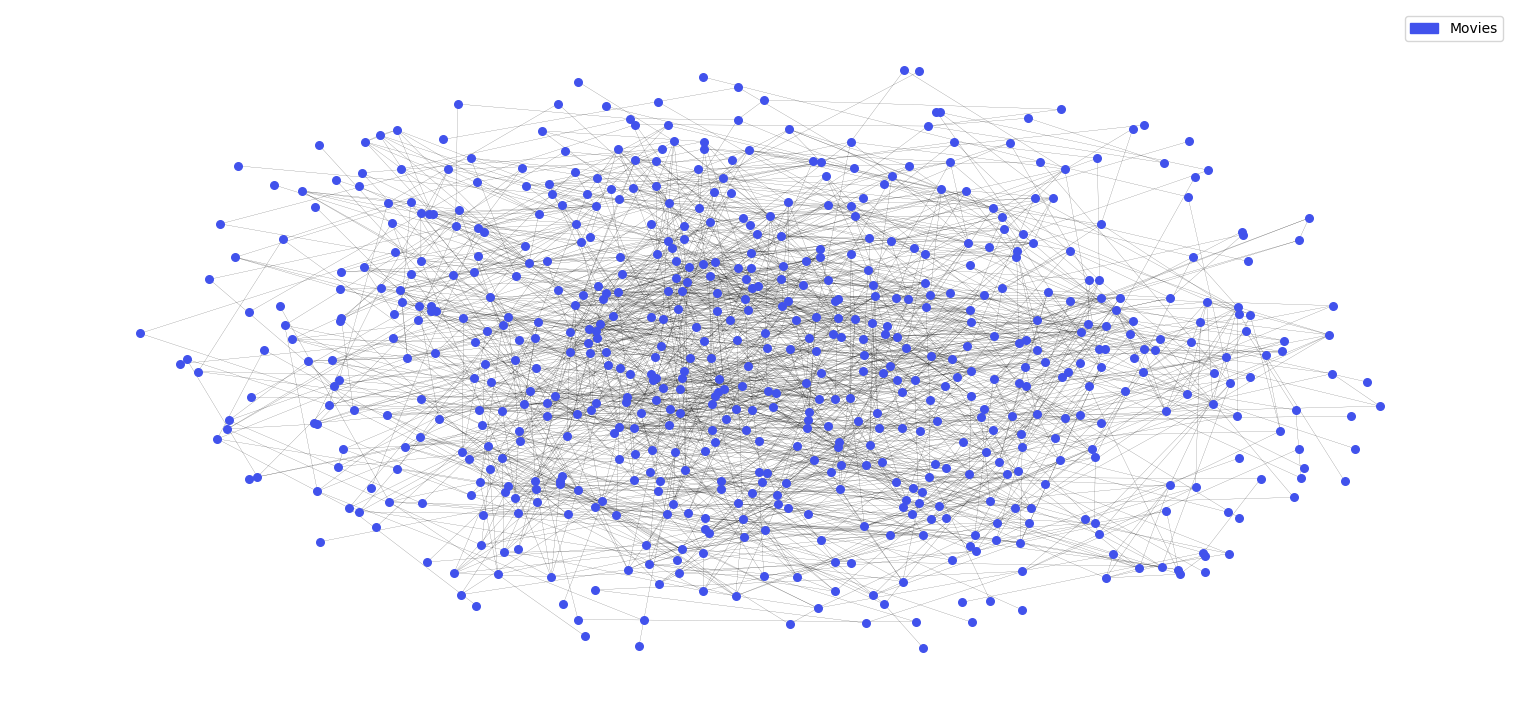

In [16]:
# Layout
plt.figure(figsize=(15, 7))
# pos = nx.spring_layout(G_movies_lcc)
pos = nx.spring_layout(G_movies_lcc, k=0.3)

# Draw network
nx.draw(G_movies_lcc, pos, node_color=d_color, edge_color='black', with_labels=False, node_size=30, width=0.1)

# Legend
movies_patch = mpatches.Patch(color=d_color, label='Movies')
plt.legend(handles=[movies_patch])
plt.show()

In [17]:
n_nodes = len(G_movies_lcc.nodes())
n_edges = len(G_movies_lcc.edges())
print("Number of nodes:", n_nodes)
print("Number of edges:", n_edges)

Number of nodes: 644
Number of edges: 2093


## **Communities**

In [21]:
# Girvan–Newman algorithm
nx_communities = nx.algorithms.centrality.edge_betweenness_centrality(G_movies_lcc)
nx_girvan_newman = nx.algorithms.community.centrality.girvan_newman(G_movies_lcc)
nx_best_community = tuple(sorted(c) for c in next(nx_girvan_newman))
num_communities = len(nx_best_community)
nx_modularity_G = nx.algorithms.community.quality.modularity(G_movies_lcc, nx_best_community)

print("Girvan–Newman:")
print("\t- Number of communities found by Girvan-Newman:", num_communities)
print("\t- Modularity:", round(nx_modularity_G,2))

Girvan–Newman:
	- Number of communities found by Girvan-Newman: 2
	- Modularity: 0.01


In [31]:
# Louvain algorithm
communities_Louvain = cl.best_partition(G_movies_lcc, random_state=seed)
n_communities_Louvain = len(np.unique(list(communities_Louvain.values())))
modularity_Louvain = community.modularity(communities_Louvain, G_movies_lcc)

print("Louvain:")
print("\t- Number of communities found by Louvain:", n_communities_Louvain)
print("\t- Modularity:", round(modularity_Louvain,2))

Louvain:
	- Number of communities found by Louvain: 17
	- Modularity: 0.65


In [28]:
# Spectral clustering - Choosing random number of clusters
np.random.seed(seed)

adj_mat = nx.to_numpy_array(G_movies_lcc)
sc = SpectralClustering(52, affinity='precomputed', n_init=100)
sc.fit(adj_mat)
nodes = list(G_movies_lcc.nodes())
communities_Spectral = communities_Spectral = [set(nodes[i] for i in np.where(sc.labels_ == j)[0]) for j in range(sc.n_clusters)]
n_communities_Spectral = len(communities_Spectral) 
modularity_Spectral = nx.algorithms.community.quality.modularity(G_movies_lcc, communities_Spectral)

print("Spectral clustering:")
print("\t- Number of communities found with spectral clustering:", n_communities_Spectral)
print("\t- Modularity:", round(modularity_Spectral,2))

Spectral clustering:
	- Number of communities found with spectral clustering: 52
	- Modularity: 0.57


In [32]:
# Spectral clustering - Finding the best number of clusters 
np.random.seed(seed)

adj_mat = nx.to_numpy_array(G_movies_lcc)
nodes = list(G_movies_lcc.nodes())

best_modularity = -np.inf
best_n_clusters = None
best_communities = None

# Try different numbers of clusters
for n_clusters in range(2, 100):
    sc = SpectralClustering(n_clusters, affinity='precomputed', n_init=100)
    sc.fit(adj_mat)

    # Convert labels array to list of sets format
    communities = [set(nodes[i] for i in np.where(sc.labels_ == j)[0]) for j in range(n_clusters)]
    modularity = nx.algorithms.community.quality.modularity(G_movies_lcc, communities)

    # Update
    if modularity > best_modularity:
        best_modularity = modularity
        best_n_clusters = n_clusters
        best_communities = communities

print("Best modularity is", best_modularity, "found with", best_n_clusters, "clusters.")
# Approx 3:33 min to run

Best modularity is 0.5881111451750644 found with 52 clusters.


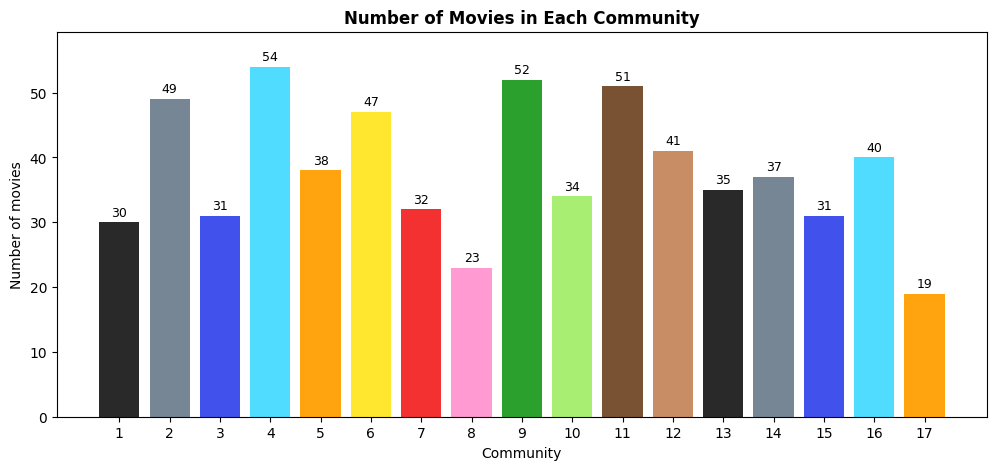

In [35]:
# Number of movies in each community
communities_Louvain_list = [set() for _ in range(n_communities_Louvain)]
for node, community_id in communities_Louvain.items():
    communities_Louvain_list[community_id].add(node)

num_movies = [len(community) for community in communities_Louvain_list]

# Histogram
plt.figure(figsize=(12, 5))
bars = plt.bar(range(1, n_communities_Louvain + 1), num_movies, color=[colors[i % len(colors)] for i in range(n_communities_Louvain)])
plt.xticks(range(1, n_communities_Louvain + 1))
plt.ylim(0, max(num_movies) + (max(num_movies)/10))
plt.xlabel('Community')
plt.ylabel('Number of movies')
plt.title('Number of Movies in Each Community', fontweight='bold')

# Add the precise number of movies above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom', fontsize=9)

plt.show()

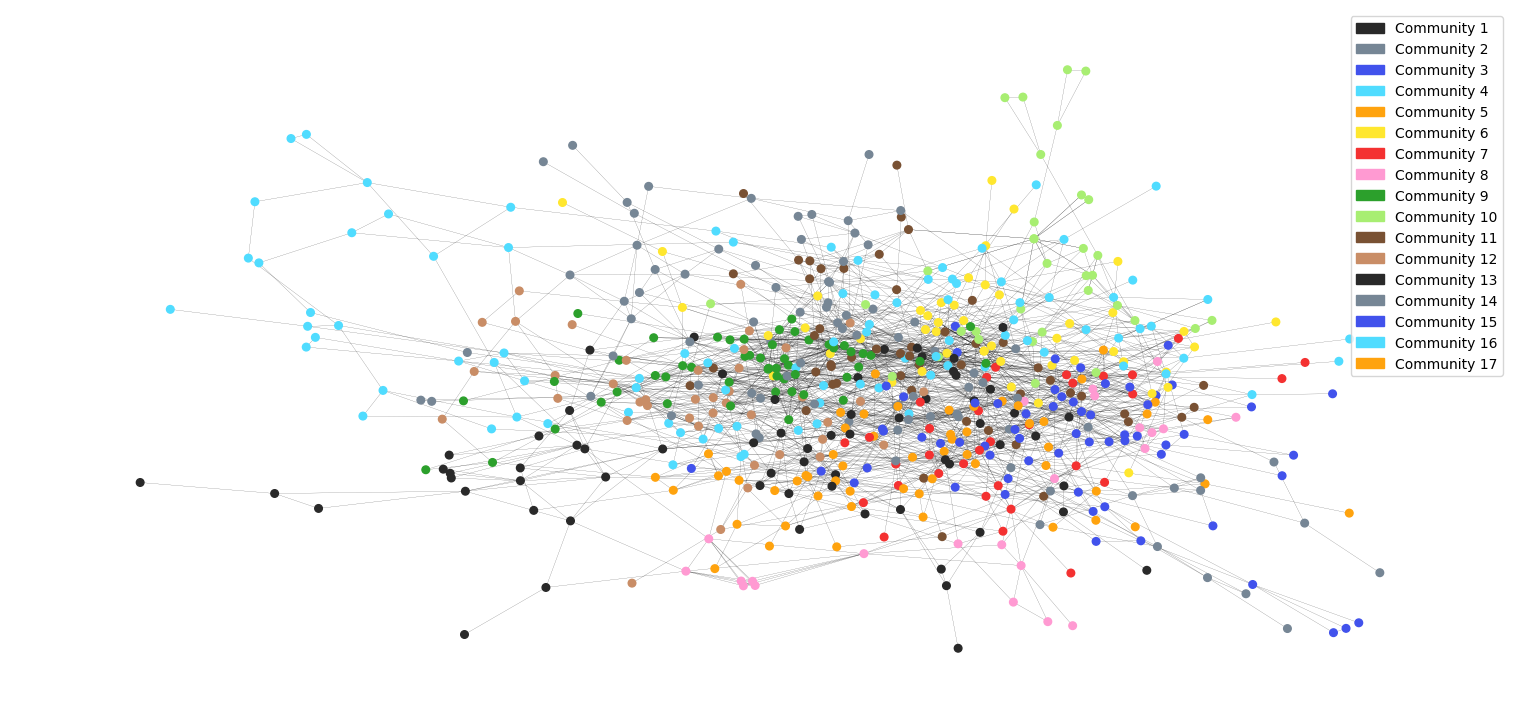

In [43]:
# Plot
plt.figure(figsize=(15, 7))
pos = nx.spring_layout(G_movies_lcc)
color_map = {node: colors[i % len(colors)] for i, community in enumerate(communities_Louvain_list) for node in community}
nx.draw(G_movies_lcc, pos, node_color=[color_map[node] for node in G_movies_lcc.nodes], edge_color='black', with_labels=False, node_size=30, width=0.1)
patches = [mpatches.Patch(color=colors[i % len(colors)], label=f'Community {i+1}') for i in range(len(communities_Louvain_list))]
plt.legend(handles=patches)
plt.show()

In [41]:
# # Communities
# communities = nx.algorithms.community.greedy_modularity_communities(G_movies_lcc)

# # Plot
# plt.figure(figsize=(15, 7))
# pos = nx.spring_layout(G_movies_lcc)
# color_map = {node: colors[i % len(colors)] for i, community in enumerate(communities) for node in community}
# nx.draw(G_movies_lcc, pos, node_color=[color_map[node] for node in G_movies_lcc.nodes], edge_color='black', with_labels=False, node_size=30, width=0.1)
# patches = [mpatches.Patch(color=colors[i % len(colors)], label=f'Community {i+1}') for i in range(len(communities))]
# plt.legend(handles=patches)
# plt.show()


In [45]:
# Number of Movies in Each Community
for i, community in enumerate(communities_Louvain_list, start=1):
    print(f'Community {i}: \t {len(community)} movies')

Community 1: 	 30 movies
Community 2: 	 49 movies
Community 3: 	 31 movies
Community 4: 	 54 movies
Community 5: 	 38 movies
Community 6: 	 47 movies
Community 7: 	 32 movies
Community 8: 	 23 movies
Community 9: 	 52 movies
Community 10: 	 34 movies
Community 11: 	 51 movies
Community 12: 	 41 movies
Community 13: 	 35 movies
Community 14: 	 37 movies
Community 15: 	 31 movies
Community 16: 	 40 movies
Community 17: 	 19 movies


In [44]:
# # Number of movies in each community
# num_movies = [len(community) for community in communities]

# # Histogram
# plt.figure(figsize=(12, 5))
# bars = plt.bar(range(1, len(communities) + 1), num_movies, color=[colors[i % len(colors)] for i in range(len(communities))])
# plt.xticks(range(1, len(communities) + 1))
# plt.ylim(0, max(num_movies) + (max(num_movies)/10))
# plt.xlabel('Community')
# plt.ylabel('Number of movies')
# plt.title('Number of Movies in Each Community', fontweight='bold')

# # Add the precise number of movies above each bar
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom', fontsize=9)

# plt.show()


In [46]:
# Number of Movies in Each Community and their titles
for i, community in enumerate(communities_Louvain_list, start=1):
    print(f'Community {i}:')
    for movie in community:
        print(f'\t- {movie}')
    print('\n')


Community 1:
	- About Schmidt
	- The League of Extraordinary Gentlemen
	- Chasing Liberty
	- A Cinderella Story
	- My Dog Skip
	- Hardball
	- Agent Cody Banks
	- A Walk to Remember
	- Finding Forrester
	- The Glass House
	- Under the Tuscan Sun
	- Unfaithful
	- Big Momma's House
	- Pootie Tang
	- The Mothman Prophecies
	- Big Fat Liar
	- Hearts in Atlantis
	- American Splendor
	- Autumn in New York
	- Agent Cody Banks 2: Destination London
	- Tomcats
	- Max
	- Kangaroo Jack
	- Raise Your Voice
	- Sideways
	- Tangled
	- Racing Stripes
	- How to Deal
	- The Perfect Storm
	- Something's Gotta Give


Community 2:
	- Best in Show
	- The Eye
	- Impostor
	- Spider-Man 2
	- The New Guy
	- Elf
	- Sin City
	- Wimbledon
	- Stuart Little 2
	- Final Destination
	- Traffic
	- The American President
	- Gosford Park
	- Valentine
	- Extreme Ops
	- Don't Say a Word
	- Spun
	- Bubble Boy
	- Atlantis: The Lost Empire
	- Slackers
	- Just Married
	- The Great Gatsby
	- The Good Girl
	- Bring It On
	- Derail

## **Degrees**
- A high degree count for a movie means that the movie shares a significant number of actors with many other movies. This means that many of the actors in the movie have also acted in a large number of other movies in the network. This could indicate that the movie has a well-known or versatile cast.

In [48]:
# Both old and new users
degrees = G_movies.degree()
top_10_movies_degree = sorted(degrees, key=lambda x: x[1], reverse=True)[:10]
for movie, degree in top_10_movies_degree:
    print(f'{movie}: {degree}')

Men of Honor: 22
Shark Tale: 21
Meet the Fockers: 19
Meet the Parents: 19
The Score: 17
Reindeer Games: 17
The Italian Job: 16
Basic: 16
The Big Bounce: 16
Godsend: 16


## **Betweenness centrality**
- Betweenness centrality is a measure of a node’s centrality in a network. It is equal to the number of shortest paths from all vertices to all others that pass through that node. A higher betweenness centrality generally means that a node is more central in the network.
- Maybe use for new users (no movies seen yet). The movies with high betweenness centrality would be good for new users as the movies are connected to many other movies in the network through shared actors. 

In [49]:
# Use for new users maybe
centrality = nx.betweenness_centrality(G_movies)
top_10_movies_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for movie, centrality in top_10_movies_centrality:
    print(f'{movie}: {centrality}')

Shark Tale: 0.027109841238036923
Nurse Betty: 0.02222911250990283
My Dog Skip: 0.021382171351750905
Men of Honor: 0.01962531226842545
Cold Mountain: 0.01902336016621135
The Big Bounce: 0.0168727321811782
Mona Lisa Smile: 0.01603293762394745
Reindeer Games: 0.015987594848746522
Saving Silverman: 0.015891467560688686
Riding in Cars with Boys: 0.015341383850319515


## **Recommend movies based on communites**
- Sort these movies based on number of common actors

In [55]:
# Should have seen at least one movie. Recommend based on latest seen movie.
def top_10_movies_common_actors(movie_title, G_movies):
    given_movie_actors = set(G_movies.nodes[movie_title]['actors'])

    # Number of common actors for each movie
    common_actors = {movie: len(given_movie_actors & set(G_movies.nodes[movie]['actors'])) for movie in G_movies.nodes if movie != movie_title}
    common_actors = {movie: actors for movie, actors in common_actors.items() if actors > 0}
    if not common_actors:
        print(f'No movies found with common actors to "{movie_title}".')
        return []
    sorted_movies = sorted(common_actors.items(), key=lambda x: x[1], reverse=True)
    top_movies = sorted_movies

    return top_movies

In [56]:
def print_movie_community(movie_title, communities):
    for i, community in enumerate(communities, start=1):
        if movie_title in community:
            print(f'"{movie_title}" is in Community {i}. These are the top 10 recommended movies with common actors:')
            sorted_movies = top_10_movies_common_actors(movie_title, G_movies)
            sorted_movies = [movie for movie in sorted_movies if movie[0] in community]
            for movie, common_actors in sorted_movies:
                print(f'\t- {movie}: {common_actors}')
            if len(sorted_movies) < 10:
                print(f'\nNote: There are only {len(sorted_movies)} movies with common actors to "{movie_title}".')
            break
    else:
        print(f'"{movie_title}" is not found in any community.')


In [57]:
print_movie_community("About Schmidt", communities_Louvain_list)

"About Schmidt" is in Community 1. These are the top 10 recommended movies with common actors:
	- Something's Gotta Give: 1
	- Hearts in Atlantis: 1
	- American Splendor: 1

Note: There are only 3 movies with common actors to "About Schmidt".


In [58]:
def get_movie_community_df(movie_title):
    # Find community of the given movie
    for community in communities_Louvain_list:
        if movie_title in community:
            df_tmdb_community = df_tmdb[df_tmdb['title'].isin(community)] # Filter dataframe so it only includes the movies in the community of the input movie           
            return df_tmdb_community

    print(f'"{movie_title}" is not found in any community.')
    return pd.DataFrame()

df_tmdb_new = get_movie_community_df(movieTitle)
df_tmdb_new

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,6,260000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",http://disney.go.com/disneypictures/tangled/,38757,"[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",en,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2010-11-24,591794936,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,They're taking adventure to new lengths.,Tangled,7.4,3330
23,214,120000000,"[{""id"": 18, ""name"": ""Drama""}]",NaN,2133,"[{""id"": 3366, ""name"": ""u.s. air force""}, {""id""...",en,The Perfect Storm,"In October 1991, a confluence of weather condi...",25.752118,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2000-03-15,325756637,130.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The storm is coming.,The Perfect Storm,6.2,597
84,438,80000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...",NaN,6964,"[{""id"": 965, ""name"": ""age difference""}, {""id"":...",en,Something's Gotta Give,Harry Sanborn is an aged music industry exec w...,16.939441,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-12-12,266728738,128.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Schmucks are people too.,Something's Gotta Give,6.3,410
102,505,78000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...",NaN,8698,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,The League of Extraordinary Gentlemen,"To prevent a world war from breaking out, famo...",47.436675,...,"[{""iso_3166_1"": ""CZ"", ""name"": ""Czech Republic""...",2003-07-11,179265204,110.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The power of seven become a league of one.,The League of Extraordinary Gentlemen,5.7,1155
162,721,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 12, ""nam...",NaN,10628,"[{""id"": 1322, ""name"": ""money delivery""}, {""id""...",en,Kangaroo Jack,"Two childhood friends, a New York hairstylist ...",10.292864,...,"[{""iso_3166_1"": ""AU"", ""name"": ""Australia""}, {""...",2003-01-17,0,89.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,He stole the money... And he's not giving it b...,Kangaroo Jack,4.3,203
208,938,50000000,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 18, ""n...",NaN,2251,"[{""id"": 596, ""name"": ""adultery""}, {""id"": 1326,...",en,Unfaithful,Connie is a wife and mother whose 11-year marr...,14.382253,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-05-10,119137784,124.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Where do you go when you've gone too far?,Unfaithful,6.3,276
252,1112,43000000,"[{""id"": 18, ""name"": ""Drama""}]",NaN,711,"[{""id"": 213, ""name"": ""upper class""}, {""id"": 38...",en,Finding Forrester,Gus van Sant tells the story of a young Africa...,19.043286,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2000-12-21,80049764,136.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"In an ordinary place, he found the one person ...",Finding Forrester,7.0,302
260,1129,32000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 27, ""name...",NaN,2637,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,The Mothman Prophecies,Reporter John Klein is plunged into a world of...,14.733513,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-01-25,55157539,119.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,What do you see?,The Mothman Prophecies,6.1,305
276,1215,65000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",NaN,10641,"[{""id"": 1605, ""name"": ""new love""}, {""id"": 2038...",en,Autumn in New York,Autumn in New York follows the sexual exploits...,8.680334,...

---
# **Topic Modelling**
---

In [485]:
#dataframe with only genres, keywords, overview and tagline
movie_text = df_tmdb[['title', 'genres', 'keywords', 'overview', 'tagline']]


## **Text preprocessing**
The text preprocessing with be done with df_tmdb, which is all movies from 2000 or later, that is also in the ratings dataset.

In [12]:
#this might not be necessary now
#convert from string to list
movie_text['genres'] = movie_text['genres'].apply(json.loads)
movie_text['keywords'] = movie_text['keywords'].apply(json.loads)

NameError: name 'movie_text' is not defined

In [488]:
#might not be necessary now
#convert from json 
genreDict = convertJSON(movie_text, 'genres')
keywordsDict = convertJSON(movie_text, 'keywords')

In [489]:
#add to dataframe
movie_text['genres'] = genreDict.values()
movie_text['keywords'] = keywordsDict.values()
movie_text

,title,genres,keywords,overview,tagline
0,Tangled,"Animation, Family","hostage, magic, horse, fairy tale, musical, pr...",When the kingdom's most wanted-and most charmi...,They're taking adventure to new lengths.
1,Spider-Man 2,"Action, Adventure, Fantasy","dual identity, love of one's life, pizza boy, ...",Peter Parker is going through a major identity...,There's a hero in all of us.
2,The Great Gatsby,"Drama, Romance","based on novel, infidelity, obsession, hope, 3d",An adaptation of F. Scott Fitzgerald's Long Is...,Reserving judgments is a matter of infinite ho...
3,Terminator 3: Rise of the Machines,"Action, Thriller, Science Fiction","saving the world, artificial intelligence, man...",It's been 10 years since John Connor saved Ear...,The Machines Will Rise.
4,The Fast and the Furious,"Action, Crime, Thriller","street gang, car race, undercover, auto-tuning...",Domenic Toretto is a Los Angeles street racer ...,Live life 1/4 mile at a time.
...,...,...,...,...,...
748,The Business of Fancydancing,"Music, Drama",independent film,"Seymour Polatkin is a successful, gay Indian p...",Sometimes going home is the hardest journey of...
749,Tadpole,"Comedy, Drama, Romance",independent film,"Beautiful, sophisticated women are all over Os...",Everyone says he should date girls his own age...
750,The Lost Skeleton of Cadavra,"Comedy, Horror, Science Fiction","monster, mutant, skeleton, alien life-form, sc...",Remember the good old days when anyone with a ...,No One Can Stand Its Mental Power!
751,Super Size Me,"Documentary, Comedy, Drama","experiment, health, junk food, food industry, ...",Morgan Spurlock subjects himself to a diet bas...,The first ever reality-based movie ... everyth...


Now that the text is on the right format, we will do some more preprocessing. For that, the function `preProcess`, is created. This function make text to lowercase, remove stop words, remove punctuation and lemmatize the text. Stopwords will be removed before removing punctuation. It is important to remove stop words before punctuation, since some words will no longer be a stop word, if punctuation is removed before stop words.
Lemmatization is used instead of stemming because the lemmatization uses lexical knowledge base to get base form of words insteaf of cutting the last part of the [word](https://medium.com/product-ai/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908). 

In [490]:
def removeStopWords(string):
    new_string = []
    stopWords = stopwords.words('english')
    
    for s in string.split():
        if s not in stopWords:
            new_string.append(s)
    final_string = ' '.join(new_string)
    
    return final_string

In [491]:
def remove(string, regex):
    result = re.sub(regex, '', string)
    
    return result

In [492]:
def removePunctuation(string): #remove: . , ! ? ' ’ : " ( ) $ - and numbers
    reg = [r'\.', r'\,', r'\?', r'\'', r'’', r'\"', r':', r':', r'\(', r'\)', r'\$', r'-', r'\d'] 

    for r in reg:
        string = remove(string, r)
        
    return string


#remove stopwords and split

In [493]:
def lemmatize(string):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    
    for w in string.split():
        lemmatized_words.append(lemmatizer.lemmatize(w))
    lemmatized_sentence = ' '.join(lemmatized_words)
    
    return lemmatized_sentence

In [494]:
def preProcess(df, column):
    lower = df[column].str.lower() #lowercase
    removeStopW = lower.apply(lambda x: removeStopWords(x)) #remove stop words
    removePunct = removeStopW.apply(lambda x: removePunctuation(x)) #remove punctuation
    df[column] = removePunct.apply(lambda x: lemmatize(x)) #lemmatize
 
    return df[column]

In [495]:
df_preprocessed = pd.DataFrame()
df_preprocessed['title'] = movie_text['title']

#preprocess text columns
df_preprocessed['overview'] = preProcess(movie_text, 'overview')
df_preprocessed['keywords'] = preProcess(movie_text, 'keywords')
df_preprocessed['genres'] = preProcess(movie_text, 'genres')
df_preprocessed['tagline'] = preProcess(movie_text, 'tagline')

In [496]:
#get all text into a list. Each document/movie is splitted by comma
overview =  ','.join(df_preprocessed.overview).split(',') 
tagline = ','.join(df_preprocessed.tagline).split(',')
genre = ','.join(df_preprocessed.genres).split(',')
keywords = ','.join(df_preprocessed.keywords).split(',')

#get a lis of list, where each list is a document/movie. Each word is as individually string
#get each string into array.
overviewText = [d.split() for d in overview]
taglineText = [d.split() for d in tagline]
genreText = [d.split() for d in genre]
keywordsText = [d.split() for d in keywords]

#create dictionary
overview_dict = corpora.Dictionary(overviewText)
tagline_dict = corpora.Dictionary(taglineText)
genre_dict = corpora.Dictionary(genreText)
keywords_dict = corpora.Dictionary(keywordsText)

#create corpus
overviewCorpus = [overview_dict.doc2bow(text) for text in overviewText]
taglineCorpus = [tagline_dict.doc2bow(text) for text in taglineText]
genreCorpus = [genre_dict.doc2bow(text) for text in genreText]
keywordsCorpus = [keywords_dict.doc2bow(text) for text in keywordsText]

## **TF-IDF**
Now that the text is preprocessed, we will start to look at the preprocessed text, starting with TF-IDF. This shows the words, that tells most about the movies/text about the movies. Meaning that it will not show the words that are often in a lot of movies. 

There are several kinds of TF-IDF, but here will be used the one taught in class. 

In [497]:
def tf_idf(corpus, dictionary, documents):
    N = len(corpus) #number of documents
    f = np.zeros((len(documents), len(dictionary)))#matrix in size: number of documents x number of unique words in all documents
    tf = np.zeros((len(documents), len(dictionary)))#matrix in size: number of documents x number of unique words in all documents
    n_t = np.zeros(len(dictionary)) #array for counting number of documents word t appears in
    
    #for d in documents: #loop through all documents
    for d in range(0,len(documents)):
        for key in dictionary.keys(): #loop through all words
            word = dictionary[key]
            wordCount = documents[d].count(word) #count occurence of word in each document
            f[d, key] = wordCount
            
            if wordCount >= 1: #if word is in document, add 1 to document count
                n_t[key] += 1 
            
        tf[d,:] = f[d,:]/max(f[d,:]) 
    
    idf = np.log2((N/n_t))
    TF_IDF = tf * idf
   
    return TF_IDF

In [498]:
TF_IDF_overview = tf_idf(overviewCorpus, overview_dict, overview)
TF_IDF_tagline = tf_idf(taglineCorpus, tagline_dict, tagline)
TF_IDF_genre = tf_idf(genreCorpus, genre_dict, genre)
TF_IDF_keywords = tf_idf(keywordsCorpus, keywords_dict, keywords)

## **Wordcloud**
Now, we plot a wordcloud, one for each of the text columns; overview, tagline, genres and keywords. 

In [499]:
def wordCloud(df, column):
    text = ' '.join(df[column])
    
    wordcloud = WordCloud().generate(text)
    return wordcloud

In [500]:
wordcloud_overview = wordCloud(df_preprocessed, 'overview')
wordcloud_tagline = wordCloud(df_preprocessed, 'tagline')
wordcloud_genre_text = wordCloud(df_preprocessed, 'genres')
wordcloud_keywords_text = wordCloud(df_preprocessed, 'keywords')

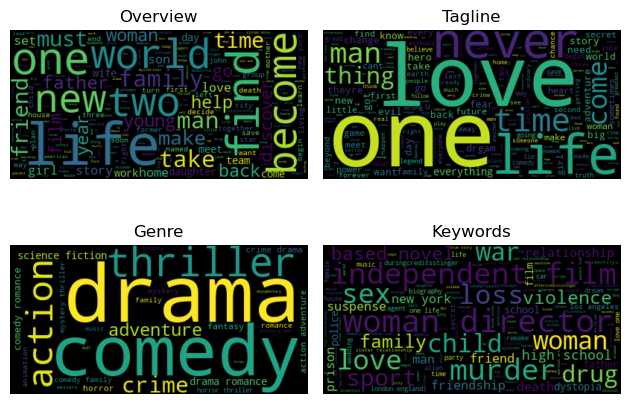

In [501]:
plt.subplots(nrows=2, ncols=2)
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_overview, interpolation = 'bilinear')
plt.axis("off")
plt.title("Overview")

plt.subplot(2, 2, 2)
plt.imshow(wordcloud_tagline, interpolation = 'bilinear')
plt.axis("off")
plt.title("Tagline")

plt.subplot(2, 2, 3)
plt.imshow(wordcloud_genre_text, interpolation = 'bilinear')
plt.axis("off")
plt.title("Genre")

plt.subplot(2, 2, 4)
plt.imshow(wordcloud_keywords_text, interpolation = 'bilinear')
plt.axis("off")
plt.title("Keywords")


plt.tight_layout()
plt.show()

In [502]:
def frequency(TF_IDF_array, dictionary):
    frequency_dict = {}
    for i in range(0, len(dictionary)):
        frequency_dict[dictionary[i]] = np.sum(TF_IDF_array[:,i])
    return frequency_dict

In [503]:
#create dict with frequency of TF-IDF
overviewFrequency = frequency(TF_IDF_overview, overview_dict)
taglineFrequency = frequency(TF_IDF_tagline, tagline_dict)
genreFrequency = frequency(TF_IDF_genre, genre_dict)
keywordsFrequency = frequency(TF_IDF_keywords, keywords_dict)

In [504]:
#create wordclouds for TF-IDF
overviewWordcloud = WordCloud().generate_from_frequencies(frequencies = overviewFrequency)
taglineWordcloud = WordCloud().generate_from_frequencies(frequencies = taglineFrequency)
genreWordcloud = WordCloud().generate_from_frequencies(frequencies = genreFrequency)
keywordsWordcloud = WordCloud().generate_from_frequencies(frequencies = keywordsFrequency)

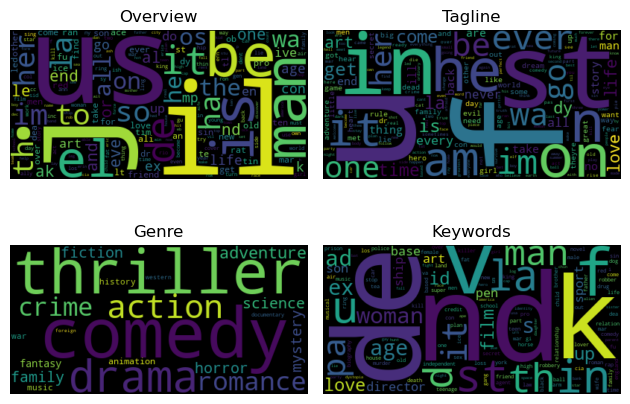

In [505]:
plt.subplots(nrows=2, ncols=2)
plt.subplot(2, 2, 1)
plt.imshow(overviewWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Overview")

plt.subplot(2, 2, 2)
plt.imshow(taglineWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Tagline")

plt.subplot(2, 2, 3)
plt.imshow(genreWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Genre")

plt.subplot(2, 2, 4)
plt.imshow(keywordsWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Keywords")


plt.tight_layout()
plt.show()

In [506]:
def getImportantWords(tf_idf, corpus, dictionary): #find 10 most important words based on TF-IDF
    important_words = []
    for d in range(0,len(corpus)):
        index_largest = tf_idf[d,:].argsort()[-10:]
        important_words.append([dictionary[i] for i in index_largest])
        
    return important_words

In [507]:
#get 10 most important words for each movie
importantWords_overview = getImportantWords(TF_IDF_overview, overviewCorpus, overview_dict)
importantWords_tagline = getImportantWords(TF_IDF_tagline, taglineCorpus, tagline_dict)
importantWords_genre = getImportantWords(TF_IDF_genre, genreCorpus, genre_dict)
importantWords_keywords = getImportantWords(TF_IDF_keywords, keywordsCorpus, keywords_dict)

In [508]:
#create corpus from important words
overviewCorpus_importantW =  [overview_dict.doc2bow(text) for text in importantWords_overview]
taglineCorpus_importantW =  [tagline_dict.doc2bow(text) for text in importantWords_tagline]
genreCorpus_importantW =  [genre_dict.doc2bow(text) for text in importantWords_genre]
keywordsCorpus_importantW =  [keywords_dict.doc2bow(text) for text in importantWords_keywords]

## **LDA**
Now for the actual topic modeeling, which is performed using Latent Dirichlet Allocation(LDA). The implementation is performed with inspiration from [this](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) article. To perform LDA, we need to know the number of topics. There are different ways to investigate this, but here we have chosen to try different number of topics, and check how the topics look, and how it looks when plotted. We want the topic to represent different topics, however we also decided to have a criteria, that there should be at least 6 movies in each topic, since we want to recommend 5 movies if possible, and the movie seen is already in the community. However, the recommender system is performed in a way, so we first find the community we are looking for a movie in. Therefore, we are performing LDA on a community, which means that there need to be at least 5 movies in each topic in each community. This was checked before choosing the number of topics. Since LDA is performed on a community, we need to define the dictionary and corpus for the community instead of all movies. It was tried to perform topic modelling with overview, keywords, tagline and genres. In the end, it was decided to use the genres in the beginning, and not in the topic modelling. It was also decided not to use tagline, since it didn't really explain a lot about the movies, so we didn't think it was a good attribute, to base a recommendation on. 

Looking at the wordclouds with and without TF-IDF, it seems that the words in TF-IDF doesn't really make any sense. It could indicate some problem in the preprocessing. Due to the result, we have chosen to the LDA on only the text without TF-IDF, since we believe this will give us the best recomendations. 

For the LDA, it has been checked that it outputs exactly 5 movies each time, unless there are less than 5 in the community. To make sure the same result is obtained each time, such that we can use the results, the random state is fixed, such that results are always the same. 

In [512]:
def recommendMovie(df, movieTitle): 
        
    n_topics_overview = int(np.floor(len(df)/10)) #number of topics is assigned such that there on average is 10 movies per topic for overview
    dictionary, corpus, text = createDocs(df, 'overview') #create corpus and dictionary for movies in community(for overview)
        
        #create LDA
    overviewLDA = LDA(n_topics_overview, corpus, dictionary)
        
        #create plots
    overviewLDA_plot = LDA_plot('results/ldavis_prepared_', overviewLDA, corpus, dictionary, n_topics_overview) 
        
        # Print the Keyword in the 10 topics for overview
        #print("Topic for community within overview")
        #pprint(overviewLDA.print_topics())
        
        #get columns for topics
    overviewTopic = assignTopic(overviewLDA, text, corpus)
        
    df['overview_topic'] = overviewTopic #add overview topic to df
        
    movie_overviewTopic = df[df.title == movieTitle].overview_topic.iloc[0] #overview topic for the seen movie
    overviewRecommend = df[df.overview_topic == movie_overviewTopic] #new df with movies to recommend based on overview topic
        
    if len(overviewRecommend) >= 10: #if enough movies, do topic modelling for keywords
            #we need to find out if there need to be over 6 movies, and if we need to divide by 11 or less(or more)
        n_topics_keywords = int(np.floor(len(overviewRecommend)/5)) #number of topics is assigned such that there on average is 11 movies per topic for keywords
   
        dictionary, corpus, text = createDocs(overviewRecommend, 'keywords') #create corpus and dictionary for movies in community(for keywords)
            
        keywordsLDA = LDA(n_topics_keywords, corpus, dictionary) #create LDA
        keywordsLDA_plot = LDA_plot('results/ldavis_prepared_', keywordsLDA, corpus, dictionary, n_topics_overview) #create plot
            
            #print("Topic for community within keywords")
            #pprint(keywordsLDA.print_topics()) # Print the Keyword in the 10 topics for keywords
            
        keywordsTopic = assignTopic(keywordsLDA, text, corpus) #get topics for movies
        overviewRecommend['keywords_topic'] = keywordsTopic #add keywords topic to recommended movies
        
        movie_keywordsTopic = overviewRecommend[overviewRecommend.title == movieTitle].keywords_topic.iloc[0] #overview topic for the seen movie
        keywordsRecommend = overviewRecommend[overviewRecommend.keywords_topic == movie_keywordsTopic] #movies to recommend based on keyword topic
            
        recommendedMovies = keywordsRecommend[keywordsRecommend.title != movieTitle].title.to_list() #find the movies in keywordsRecommend, which is not the movie just seen
    
    else: #if there are at most 6 movies, recommend the movies(except the one just seen)
        print("No topic modelling performed on keywords")
        recommendedMovies = overviewRecommend[overviewRecommend.title != movieTitle].title.to_list() #find the movies in the overviewRecommend, which is not the movie just seen
        keywordsLDA_plot = "No topic modelling were performed on keywords due to few movies in the community after filtering based overview"

        
    #else:
     #   recommendedMovies = df[df.title != movieTitle].title.to_list() #recommend movies in the community, except movie just seen
      #  overviewLDA_plot = 'No topic modelling were performed on overview due to few movies in the community'
       # keywordsLDA_plot =  'No topic modelling were performed on keywords due to few movies in the community'
    return recommendedMovies[0:5], overviewLDA_plot, keywordsLDA_plot

In [ ]:
#just to test - delete after
c = 0
#i = 0
movies = list(communities[c])
#movie = list(communities[c])[i]
#movie
for i in movies:
    print(i)
    df_tmdb_new = get_movie_community_df(i) #the first 3 lines, should be deleted
    communityText = df_preprocessed[df_preprocessed.title.isin(df_tmdb_new.title)]
    movies_recommend, overviewPlot, keywordsPlot = recommendMovie(communityText, i)
    print(i, movies_recommend)


#eulogy is not in df, but is in community

The Shipping News
The Shipping News ['After the Sunset', 'The Life of David Gale', 'Closer', 'Godsend', 'Triangle']
Kinsey
Kinsey ['Beyond Borders', 'The Yards', 'The Amityville Horror', 'Anything Else', 'Frida']
Catch That Kid
No topic modelling performed on keywords
Catch That Kid ['Transcendence', 'Cold Mountain', 'The Italian Job', 'What Planet Are You From?', 'Bad Santa']
Anything Else
Anything Else ['Beyond Borders', 'The Yards', 'The Amityville Horror', 'Frida', 'Kinsey']
Secret Window
Secret Window ['Pay It Forward', 'About a Boy']
Confessions of a Teenage Drama Queen
Confessions of a Teenage Drama Queen ['I Heart Huckabees', 'Fahrenheit 9/11', 'Anatomy']
Town & Country
Town & Country ['Lucky Numbers', 'Casino', 'The Watcher', 'Veronica Guerin', 'The Banger Sisters']
Cold Mountain
No topic modelling performed on keywords
Cold Mountain ['Transcendence', 'The Italian Job', 'What Planet Are You From?', 'Bad Santa', 'Catch That Kid']
The Aviator
The Aviator ['The Incredible Hulk', 

What Women Want ['Intolerable Cruelty', 'Heist', 'The Tailor of Panama']
Bad Santa
No topic modelling performed on keywords
Bad Santa ['Transcendence', 'Cold Mountain', 'The Italian Job', 'What Planet Are You From?', 'Catch That Kid']
Bowling for Columbine
Bowling for Columbine ["The Emperor's New Groove", 'Meet the Parents', 'Elizabeth', 'The Jungle Book 2', 'High Fidelity']
Love Actually
Love Actually ['Cast Away', 'Ice Age', "What's the Worst That Could Happen?", 'Keeping the Faith', 'Land of the Dead']
Supernova
Supernova ['Sky Captain and the World of Tomorrow', 'Meet the Fockers', 'The Life Aquatic with Steve Zissou', 'Zoolander', 'Quills']
I Heart Huckabees
I Heart Huckabees ['Confessions of a Teenage Drama Queen', 'Fahrenheit 9/11', 'Anatomy']
The Banger Sisters
The Banger Sisters ['Town & Country', 'Lucky Numbers', 'Casino', 'The Watcher', 'Veronica Guerin']
Anna Karenina
Anna Karenina ['A.I. Artificial Intelligence', 'Bandits', 'Finding Neverland', 'Buffalo Soldiers', 'In the

Analyze That ['Monster']
Resident Evil
Resident Evil ['The Incredible Hulk', 'The Aviator', 'The Three Musketeers', 'The Village', 'The Musketeer']
Red Dragon
Red Dragon ['Shark Tale', 'Sweet November', 'Eternal Sunshine of the Spotless Mind', 'Drowning Mona', 'Tadpole']
Psycho Beach Party
Psycho Beach Party ['Sky Captain and the World of Tomorrow', 'Meet the Fockers', 'Supernova', 'The Life Aquatic with Steve Zissou', 'Zoolander']
Meet the Fockers
Meet the Fockers ['Sky Captain and the World of Tomorrow', 'Supernova', 'The Life Aquatic with Steve Zissou', 'Zoolander', 'Quills']
Secretary
Secretary ['Town & Country', 'Lucky Numbers', 'Casino', 'The Watcher', 'Veronica Guerin']
The Score
The Score ['Teenage Mutant Ninja Turtles', 'The Legend of Bagger Vance', 'Alfie', 'The Country Bears', 'Confidence']
In the Bedroom
In the Bedroom ['A.I. Artificial Intelligence', 'Bandits', 'Anna Karenina', 'Finding Neverland', 'Buffalo Soldiers']
Shallow Hal
No topic modelling performed on keywords
Sh

In [510]:
#c = 0
#movies = list(communities[c])[0]
movies = "Eulogy"
df_tmdb_new = get_movie_community_df(movies) #the first 3 lines, should be deleted

communityText = df_preprocessed[df_preprocessed.title.isin(df_tmdb_new.title)]
df = communityText

#to test function
n_topics_overview = int(np.floor(len(df)/10))

dictionary, corpus, text = createDocs(df, 'overview')

overviewLDA = LDA(n_topics_overview, corpus, dictionary)
overviewTopic = assignTopic(overviewLDA, text, corpus)

df['overview_topic'] = overviewTopic #add overview topic to df
movie_overviewTopic = df[df.title == movies].overview_topic.iloc[0]
overviewRecommend = df[df.overview_topic == movie_overviewTopic]

#if len(overviewRecommend) >= 10:
    #n_topics_keywords = int(np.floor(len(overviewRecommend)/5))
    #dictionary, corpus, text = createDocs(overviewRecommend, 'keywords')
    #keywordsLDA = LDA(n_topics_keywords, corpus, dictionary) #create LDA
    
    #keywordsTopic = assignTopic(keywordsLDA, text, corpus) #get topics for movies
    #overviewRecommend['keywords_topic'] = keywordsTopic #add keywords topic to recommended movies
    #movie_keywordsTopic = overviewRecommend[overviewRecommend.title == movies].keywords_topic.iloc[0]
    
    #keywordsRecommend = overviewRecommend[overviewRecommend.keywords_topic == movie_keywordsTopic]
    #recommendedMovies = keywordsRecommend[keywordsRecommend.title != movies].title.to_list()[0:5]

"Eulogy" is not found in any community.


AttributeError: 'DataFrame' object has no attribute 'title'

The Shipping News
Kinsey
Catch That Kid
Anything Else
Secret Window
Confessions of a Teenage Drama Queen
Town & Country
Cold Mountain
The Aviator
The Mummy Returns
Blow
Bruce Almighty
Carnage
The Country Bears
Hide and Seek
Enemy at the Gates
Along Came Polly
Beyond the Sea
Frida
The Three Musketeers
Small Time Crooks
The Legend of Bagger Vance
The Road
What's the Worst That Could Happen?
Sin City
The Musketeer
Sky Captain and the World of Tomorrow
Beyond Borders
The Incredible Hulk
The Jacket
Ice Age
Resident Evil: Apocalypse
Bend It Like Beckham
Pirates of the Caribbean: The Curse of the Black Pearl
Blade: Trinity
Godsend
Inside Deep Throat
Dark Blue
Cleopatra
Love & Basketball
Heist
Hollywood Ending
Zoolander
Darkness
The Life Aquatic with Steve Zissou
Confidence
Chocolat
Spun
Sunshine State
The Holy Girl
The Emperor's New Groove
Tadpole
The Village
What Planet Are You From?
Elizabeth
The Beach
Original Sin
8 Women
Veronica Guerin
Kingdom of Heaven
The Amityville Horror
Man on the M

In [156]:
#also just to test
movies_recommend, overviewPlot, keywordsPlot = recommendMovie(communityText, movie)

Topic for community within overview
[(0,
  '0.009*"city" + 0.007*"new" + 0.007*"band" + 0.006*"life" + 0.006*"rock" + '
  '0.005*"evil" + 0.005*"steel" + 0.005*"dragon" + 0.005*"future" + '
  '0.005*"called"'),
 (1,
  '0.009*"sam" + 0.007*"back" + 0.006*"two" + 0.006*"guard" + 0.006*"prisoner" '
  '+ 0.006*"fall" + 0.006*"hank" + 0.006*"man" + 0.005*"woman" + 0.005*"one"'),
 (2,
  '0.010*"new" + 0.009*"daughter" + 0.009*"city" + 0.007*"mother" + '
  '0.007*"york" + 0.007*"two" + 0.006*"last" + 0.006*"family" + '
  '0.005*"empress" + 0.005*"find"'),
 (3,
  '0.005*"lucy" + 0.005*"life" + 0.005*"end" + 0.005*"man" + 0.004*"bruce" + '
  '0.004*"army" + 0.004*"team" + 0.004*"ranger" + 0.004*"time" + '
  '0.004*"woman"'),
 (4,
  '0.014*"jack" + 0.010*"pilot" + 0.010*"friend" + 0.006*"goon" + 0.006*"make" '
  '+ 0.006*"death" + 0.006*"man" + 0.006*"project" + 0.006*"he" + '
  '0.006*"face"'),
 (5,
  '0.008*"life" + 0.007*"bear" + 0.007*"friend" + 0.006*"charlie" + '
  '0.006*"find" + 0.006*"g

In [138]:
communityText = df_preprocessed[df_preprocessed.title.isin(df_tmdb_new.title)]#preprocessed text for movies in the community

In [65]:
def createDocs(df, column): #create dictionary and corpus for movies in community
    text_list = ','.join(df[column]).split(',') #get all text into a list. Each document/movie is splitted by comma
    text = [d.split() for d in text_list] #get a lis of list, where each list is a document/movie. Each word is as individually string. get each string into array.
    
    #create dictionary
    dictionary = corpora.Dictionary(text) #create dictionary
    #create corpus
    corpus = [dictionary.doc2bow(t) for t in text]
    
    return dictionary, corpus, text

In [168]:
def LDA(n_topics, corpus, dictionary): #create function for LDA
    lda = gensim.models.LdaMulticore(corpus = corpus,
                                       id2word=dictionary,
                                       num_topics=n_topics, 
                                     random_state= 5)
    return lda

In [169]:
def LDA_plot(path, lda_model, corpus, dictionary, n_topics): #function for plotting topics
    #Visualize topics
    pyLDAvis.enable_notebook()
    LDAvis_data_filepath = os.path.join(path + str(n_topics))
    
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
            
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
        
    pyLDAvis.save_html(LDAvis_prepared, path+ str(n_topics) +'.html')
    
    return LDAvis_prepared 

In [170]:
def assignTopic(lda, text, corpus): #assign topic with highest score
    assignedTopic = []
    for t in lda[corpus]: #loop through topics
        topic = []
        score = []
        for i in t:
            topic.append(i[0])
            score.append(i[1])
        assignedTopic.append(topic[np.argmax(score)]) #assign topic with highest score
    return assignedTopic

!!**Explain recommendMovie**(the function)
find the number that should at least be in each keywords topic

In [264]:
def recommendMovie(df, movieTitle): 
    if len(df) > 6: #only do topic modelling, if there are more than 6 movies in community, otherwise recommend those
        
        n_topics_overview = int(np.floor(len(df)/10)) #number of topics is assigned such that there on average is 10 movies per topic for overview
        dictionary, corpus, text = createDocs(df, 'overview') #create corpus and dictionary for movies in community(for overview)
        
        #create LDA
        overviewLDA = LDA(n_topics_overview, corpus, dictionary)
        
        #create plots
        overviewLDA_plot = LDA_plot('results/ldavis_prepared_', overviewLDA, corpus, dictionary, n_topics_overview) 
        
        # Print the Keyword in the 10 topics for overview
        #print("Topic for community within overview")
        #pprint(overviewLDA.print_topics())
        
        #get columns for topics
        overviewTopic = assignTopic(overviewLDA, text, corpus)
        
        df['overview_topic'] = overviewTopic #add overview topic to df
        
        movie_overviewTopic = df[df.title == movieTitle].overview_topic.iloc[0] #overview topic for the seen movie
        overviewRecommend = df[df.overview_topic == movie_overviewTopic] #new df with movies to recommend based on overview topic
        
        if len(overviewRecommend) >= 10: #if enough movies, do topic modelling for keywords
            #we need to find out if there need to be over 6 movies, and if we need to divide by 11 or less(or more)
            n_topics_keywords = int(np.floor(len(overviewRecommend)/5)) #number of topics is assigned such that there on average is 11 movies per topic for keywords
   
            dictionary, corpus, text = createDocs(overviewRecommend, 'keywords') #create corpus and dictionary for movies in community(for keywords)
            
            keywordsLDA = LDA(n_topics_keywords, corpus, dictionary) #create LDA
            keywordsLDA_plot = LDA_plot('results/ldavis_prepared_', keywordsLDA, corpus, dictionary, n_topics_overview) #create plot
            
            #print("Topic for community within keywords")
            #pprint(keywordsLDA.print_topics()) # Print the Keyword in the 10 topics for keywords
            
            keywordsTopic = assignTopic(keywordsLDA, text, corpus) #get topics for movies
            overviewRecommend['keywords_topic'] = keywordsTopic #add keywords topic to recommended movies
        
            movie_keywordsTopic = overviewRecommend[overviewRecommend.title == movieTitle].keywords_topic.iloc[0] #overview topic for the seen movie
            keywordsRecommend = overviewRecommend[overviewRecommend.keywords_topic == movie_keywordsTopic] #movies to recommend based on keyword topic
            
            recommendedMovies = keywordsRecommend[keywordsRecommend.title != movieTitle].title.to_list() #find the movies in keywordsRecommend, which is not the movie just seen
    
        else: #if there are at most 6 movies, recommend the movies(except the one just seen)
            recommendedMovies = overviewRecommend[overviewRecommend.title != movieTitle].title.to_list() #find the movies in the overviewRecommend, which is not the movie just seen
            keywordsLDA_plot = "No topic modelling were performed on keywords due to few movies in the community after filtering based overview"

        
    else:
        recommendedMovies = df[df.title != movieTitle].title.to_list() #recommend movies in the community, except movie just seen
        overviewLDA_plot = 'No topic modelling were performed on overview due to few movies in the community'
        keywordsLDA_plot =  'No topic modelling were performed on keywords due to few movies in the community'
    return recommendedMovies[0:5], overviewLDA_plot, keywordsLDA_plot

In [262]:
a = [1,2,3]

In [263]:
a[0:5]

[1, 2, 3]

In [134]:
c = 0
i = 0
movies = list(communities[c])
movie = list(communities[c])[i]
movie
#for i in movies:
#    movie = i


df_tmdb_new = get_movie_community_df(movie) #the first 3 lines, should be deleted
df_tmdb_new

#7, 8, 9, 10, 11

#communityIndex = df_tmdb_new.index.to_list()
#len(df_tmdb_new)

#c = 0, 1,2 

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
1,30,200000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spider-man2/,558,"[{""id"": 851, ""name"": ""dual identity""}, {""id"": ...",en,Spider-Man 2,Peter Parker is going through a major identity...,35.149586,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2004-06-25,783766341,127.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,There's a hero in all of us.,Spider-Man 2,6.7,4321
2,49,105000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",NaN,64682,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,The Great Gatsby,An adaptation of F. Scott Fitzgerald's Long Is...,61.196071,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2013-05-10,351040419,143.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Reserving judgments is a matter of infinite ho...,The Great Gatsby,7.3,3769
6,119,150000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www2.warnerbros.com/batmanbegins/index....,272,"[{""id"": 486, ""name"": ""himalaya""}, {""id"": 779, ...",en,Batman Begins,"Driven by tragedy, billionaire Bruce Wayne ded...",115.040024,...,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2005-06-10,374218673,140.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Evil fears the knight.,Batman Begins,7.5,7359
11,159,139000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...",http://www.sonypictures.com/movies/spider-man/,557,"[{""id"": 1014, ""name"": ""loss of lover""}, {""id"":...",en,Spider-Man,After being bitten by a genetically altered sp...,82.502566,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-05-01,821708551,121.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,With great power comes great responsibility.,Spider-Man,6.8,5265
12,165,137000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",NaN,1927,"[{""id"": 387, ""name"": ""california""}, {""id"": 582...",en,Hulk,"Bruce Banner, a genetics researcher with a tra...",34.981698,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-06-19,245360480,138.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Unleash the hero within,Hulk,5.3,1533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,4174,1800000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",http://padreamaro.ad2.com/site/home_eng.htm,542,"[{""id"": 1786, ""name"": ""heart attack""}, {""id"": ...",es,El Crimen del Padre Amaro,The young Father Amaro is put to the test. He ...,2.179428,...,"[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}]",2002-10-01,0,118.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Lead us not into temptation,The Crime of Padre Amaro,6.2,36
723,4234,1500000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 9648, ""n...",NaN,10972,"[{""id"": 222, ""name"": ""schizophrenia""}, {""id"": ...",en,Session 9,Tensions rise within an asbestos cleaning crew...,11.064228,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2001-08-10,373967,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Fear is a place.,Session 9,6.2,251
729,4373,0,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",http://www.sonyclassics.com/alltherealgirls/,13132,"[{""id"": 531, ""name"": ""southern usa""}, {""id"": 1...",en,All the Real Girls,"In a small North Carolina town, Paul, a womani...",3.659240,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-08-01,0,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Love is a puzzle. These are the pieces.,All the Real Girls,5.9,30
730,4375,1000000,"[{""id"": 18, ""name"": ""Drama""}]

In [ ]:
#make sure to do a seed in LDA.

#try each community. And then loop through each movie as movieTitle.
#We need to make sure that this run with any movie, and we need to make sure, that we recommend 5 movies.

#So also add to the end, that we return the first 5 movies.
#We need to make sure that if there are any order they are in from df_tmdb_new, that it is the same order, that is returned. 


In [126]:
movies_recommend, overviewPlot, keywordsPlot = recommendMovie(communityText, movieTitle)

Topic for community within overview
[(0,
  '0.007*"agent" + 0.006*"young" + 0.006*"black" + 0.006*"girl" + 0.006*"evil" '
  '+ 0.005*"new" + 0.005*"make" + 0.005*"year" + 0.005*"father" + '
  '0.004*"find"'),
 (1,
  '0.010*"life" + 0.009*"new" + 0.009*"wife" + 0.007*"daughter" + 0.006*"love" '
  '+ 0.006*"help" + 0.005*"suddenly" + 0.005*"man" + 0.005*"core" + '
  '0.005*"friend"'),
 (2,
  '0.013*"life" + 0.007*"oscar" + 0.007*"eve" + 0.005*"two" + 0.005*"best" + '
  '0.005*"car" + 0.005*"sean" + 0.004*"star" + 0.004*"film" + 0.004*"story"'),
 (3,
  '0.012*"life" + 0.005*"face" + 0.005*"must" + 0.004*"airline" + '
  '0.004*"victim" + 0.004*"put" + 0.004*"new" + 0.004*"world" + 0.004*"two" + '
  '0.003*"hole"'),
 (4,
  '0.006*"he" + 0.006*"love" + 0.005*"life" + 0.005*"find" + 0.005*"work" + '
  '0.005*"brother" + 0.005*"one" + 0.005*"eve" + 0.005*"oscar" + 0.004*"–"'),
 (5,
  '0.015*"one" + 0.008*"life" + 0.008*"joel" + 0.007*"new" + 0.006*"story" + '
  '0.006*"tell" + 0.006*"griffin" 

In [127]:
movies_recommend


['Raise Your Voice', 'A Mighty Wind', '11:14']

In [128]:
overviewPlot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.056057  0.033179       1        1  12.310408
5     -0.008309  0.102860       2        1  12.142147
3      0.038568  0.066424       3        1  12.128277
4     -0.104814 -0.074647       4        1  10.471656
1      0.061119 -0.010100       5        1   9.875326
6      0.073413 -0.095888       6        1   9.773855
9     -0.032581  0.017163       7        1   9.479795
0      0.082557 -0.007420       8        1   8.688749
7     -0.003539 -0.009238       9        1   7.809527
2     -0.050357 -0.022332      10        1   7.320260, topic_info=        Term       Freq      Total Category  logprob  loglift
250    agent   6.000000   6.000000  Default  30.0000  30.0000
2048   oscar   4.000000   4.000000  Default  29.0000  29.0000
2040     eve   4.000000   4.000000  Default  28.0000  28.0000
1189    joel   5.000000   5.000000  Default  27.0000  27.0000
63       new  12.000000  12.000000  Default  26.0000  26.0000
...      ...        ...        ...      ...      ...      ...
102     come   0.687144   3.056946  Topic10  -5.9300   1.1219
84       get   0.713601   8.850984  Topic10  -5.8922   0.0966
54    friend   0.703955   9.965381  Topic10  -5.9059  -0.0356
261      one   0.661737  16.203617  Topic10  -5.9677  -0.5836
182    woman   0.645324   4.909506  Topic10  -5.9928   0.5853

[624 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1863      2  0.703006             a
1773      7  0.822377  accidentally
991       4  0.561741        across
400       6  0.525852           act
76        1  0.792697      adjuster
...     ...       ...           ...
389       8  0.252993         young
389       9  0.126497         young
531       1  0.218237             –
531       2  0.436473             –
531       4  0.436473             –

[876 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 4, 5, 2, 7, 10, 1, 8, 3])

In [129]:
keywordsPlot

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.011355  0.0       1        1  52.939446
1     -0.011355  0.0       2        1  47.060554, topic_info=        Term      Freq     Total Category  logprob  loglift
20     chase  2.000000  2.000000  Default  30.0000  30.0000
85   android  1.000000  1.000000  Default  29.0000  29.0000
84     alien  1.000000  1.000000  Default  28.0000  28.0000
60     heart  1.000000  1.000000  Default  27.0000  27.0000
106   singer  2.000000  2.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
4      agent  0.870175  1.633628   Topic2  -4.3198   0.1239
12    secret  0.771267  1.612883   Topic2  -4.4405   0.0160
63    police  0.729956  1.604218   Topic2  -4.4955  -0.0337
37    murder  0.796553  2.101884   Topic2  -4.4082  -0.2166
20     chase  0.651562  2.555177   Topic2  -4.6091  -0.6128

[104 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
51        2  0.912270       abuse
4         1  0.612135       agent
4         2  0.612135       agent
84        2  0.883662       alien
85        2  0.882406     android
...     ...       ...         ...
65        2  0.606521    suspense
66        2  0.905258  transplant
50        1  0.953865      venice
13        2  0.906589       woman
83        2  0.900058  workaholic

[77 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [558]:

df_tmdb_new['keywords_topic'] = keywordsTopic

In [584]:
#topic for overview for movie title
movie_overviewTopic = df_tmdb_new[df_tmdb_new.title == movieTitle].overview_topic.iloc[0]
overviewTopic_index = df_tmdb_new[df_tmdb_new.overview_topic == movie_overviewTopic].title.index.to_list() #index of movies with same topic in overview

In [593]:
#now choose the titles, and check who can be chosen with keywordsTopic as well. Another filtering. 
#If list is empty in the end, recommend the one in overviewTopic_index


In [589]:
keywordsTopic_index

[148, 156, 221, 254, 295, 370, 430, 445, 549, 573, 612, 638, 644, 647]

['The Core',
 'The Longest Yard',
 'The Italian Job',
 'Casino',
 'Death to Smoochy',
 'Insomnia',
 'Monster-in-Law',
 'High Crimes',
 'Dumb and Dumberer: When Harry Met Lloyd',
 'Love & Basketball',
 'Auto Focus',
 'Lost in Translation']

In [ ]:
movieTitle = "The Italian Job"

In [20]:
df_tmdb

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,6,260000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",http://disney.go.com/disneypictures/tangled/,38757,"[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",en,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2010-11-24,591794936,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,They're taking adventure to new lengths.,Tangled,7.4,3330
1,30,200000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spider-man2/,558,"[{""id"": 851, ""name"": ""dual identity""}, {""id"": ...",en,Spider-Man 2,Peter Parker is going through a major identity...,35.149586,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2004-06-25,783766341,127.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,There's a hero in all of us.,Spider-Man 2,6.7,4321
2,49,105000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",NaN,64682,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,The Great Gatsby,An adaptation of F. Scott Fitzgerald's Long Is...,61.196071,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2013-05-10,351040419,143.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Reserving judgments is a matter of infinite ho...,The Great Gatsby,7.3,3769
3,93,200000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",NaN,296,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,Terminator 3: Rise of the Machines,It's been 10 years since John Connor saved Ear...,69.405188,...,"[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",2003-07-02,435000000,109.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Machines Will Rise.,Terminator 3: Rise of the Machines,5.9,2143
4,99,38000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9799,"[{""id"": 542, ""name"": ""street gang""}, {""id"": 83...",en,The Fast and the Furious,Domenic Toretto is a Los Angeles street racer ...,6.909942,...,"[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",2001-06-22,207283925,106.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Live life 1/4 mile at a time.,The Fast and the Furious,6.6,3428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,4678,200000,"[{""id"": 10402, ""name"": ""Music""}, {""id"": 18, ""n...",NaN,40920,"[{""id"": 10183, ""name"": ""independent film""}]",en,The Business of Fancydancing,"Seymour Polatkin is a successful, gay Indian p...",0.061040,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-01-14,0,103.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Sometimes going home is the hardest journey of...,The Business of Fancydancing,8.0,2
749,4703,150000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",NaN,39141,"[{""id"": 10183, ""name"": ""independent film""}]",en,Tadpole,"Beautiful, sophisticated women are all over Os...",8.570328,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-11-01,2891288,78.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Everyone says he should date girls his own age...,Tadpole,5.5,19
750,4728,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 27, ""nam...",NaN,18841,"[{""id"": 1299, ""name"": ""monster""}, {""id"": 1852,...",en,The Lost Skeleton of Cadavra,Remember the good old days when anyone with a ...,1.680525,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2001-09-12,0,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,No One Can Stand Its Mental Power!,The Lost Skeleton of Cadavra,6.5,30
751,4742,65000,"[{""id"": 99, ""name"": ""Documentary""}, {""id"

In [ ]:
c = 3
movie = list(communities[c])[0]
df_tmdb_new = get_movie_community_df(movie) #the first 3 lines, should be deleted

#7, 8, 9, 10, 11

communityIndex = df_tmdb_new.index.to_list()
len(df_tmdb_new)

#c = 0, 1,2 

In [45]:
mostPopular_index = df_tmdb.popularity.nlargest(5).index.to_list() #index of 5 most popular movies(of given day)
mostPopularMovies = df_tmdb.iloc[mostPopular_index].title.to_list() #list of 5 most popular movies(of given day)

['Pirates of the Caribbean: The Curse of the Black Pearl',
 'Teenage Mutant Ninja Turtles',
 'Harry Potter and the Chamber of Secrets',
 'Spirited Away',
 'Batman Begins']

---
# **Recommendation**
---

In [140]:
userRatings = ratings[ratings.User_ID == 712664]
rating = userRatings[userRatings.Movie_ID == 3].Rating.iloc[0]

In [144]:
#remove movies not in df_tmdb(after some were removed)
#df_movies = movies_subset[movies_subset.Name.isin(df_tmdb.title)]
#df_credits = credits[credits.title.isin(df_tmdb.title)]
#df_ratings = ratings[ratings.Movie_ID.isin(df_movies)]
#df_tmdb


3756

In [179]:
df_movies

,Movie_ID,Year,Name
29,30,2003,Something's Gotta Give
88,89,2000,Chain of Command
147,148,2001,Sweet November
186,187,2002,Death to Smoochy
215,216,2000,Impostor
...,...,...,...
17661,17662,2003,The Guru
17671,17672,2000,My Dog Skip
17691,17692,2002,Scooby-Doo
17702,17703,2003,Hulk


In [ ]:
# We chose that to define a "good" movie as a movie with rating at 3 or higher

In [219]:
def recommendation(userID, movieTitle, rating_df, movie_df): #if userID is None, it is a new user
    if userID == None:
        #recommendedMovies = mostPopularMovies 
        a= 1
    else:
        userRatings = rating_df[rating_df.User_ID == userID] #rating from user
        movieID = movie_df[movie_df.Name == movieTitle].Movie_ID.iloc[0] #ID for seen movie
        rating = userRatings[userRatings.Movie_ID == movieID].Rating.iloc[0] #rating for seen movie
        
        if rating >= 3: 
            a = filterByGenre(movieTitle, df_tmdb)
            
            
    
        
        
    return a

In [221]:
recommendation(1351377, movieTitle, df_ratings, df_movies)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
2,49,105000000,"Drama, Romance",NaN,64682,"based on novel, infidelity, obsession, hope, 3d",en,The Great Gatsby,An adaptation of F. Scott Fitzgerald's Long Is...,61.196071,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2013-05-10,351040419,143.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Reserving judgments is a matter of infinite ho...,The Great Gatsby,7.3,3769
6,119,150000000,"Action, Crime, Drama",http://www2.warnerbros.com/batmanbegins/index....,272,"himalaya, martial arts, dc comics, crime fight...",en,Batman Begins,"Driven by tragedy, billionaire Bruce Wayne ded...",115.040024,...,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2005-06-10,374218673,140.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Evil fears the knight.,Batman Begins,7.5,7359
7,145,175000000,"Adventure, Drama, War",NaN,652,"brother brother relationship, adultery, mythol...",en,Troy,"In year 1250 B.C. during the late Bronze age, ...",66.803149,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2004-05-13,497409852,163.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,For passion. For honor. For destiny. For victo...,Troy,6.9,2759
9,150,140000000,"Action, Adventure, Comedy, Science Fiction",http://www.sonypictures.com/homevideo/meninbla...,608,"saving the world, secret identity, sun glasses...",en,Men in Black II,"Kay and Jay reunite to provide our best, last ...",91.332849,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-07-03,441818803,88.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Same Planet. New Scum.,Men in Black II,6.0,3114
10,156,140000000,"Drama, Action, War, History",NaN,616,"japan, war crimes, sense of guilt, swordplay, ...",en,The Last Samurai,Nathan Algren is an American hired to instruct...,52.341226,...,"[{""iso_3166_1"": ""JP"", ""name"": ""Japan""}, {""iso_...",2003-12-05,456758981,154.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,"In the face of an enemy, in the heart of one m...",The Last Samurai,7.3,1895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,4678,200000,"Music, Drama",NaN,40920,independent film,en,The Business of Fancydancing,"Seymour Polatkin is a successful, gay Indian p...",0.061040,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-01-14,0,103.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Sometimes going home is the hardest journey of...,The Business of Fancydancing,8.0,2
749,4703,150000,"Comedy, Drama, Romance",NaN,39141,independent film,en,Tadpole,"Beautiful, sophisticated women are all over Os...",8.570328,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-11-01,2891288,78.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Everyone says he should date girls his own age...,Tadpole,5.5,19
750,4728,0,"Comedy, Horror, Science Fiction",NaN,18841,"monster, mutant, skeleton, alien life-form, sc...",en,The Lost Skeleton of Cadavra,Remember the good old days when anyone with a ...,1.680525,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2001-09-12,0,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,No One Can Stand Its Mental Power!,The Lost Skeleton of Cadavra,6.5,30
751,4742,65000,"Documentary, Comedy, Drama",NaN,9372,"experiment, health, junk food, food industry, ...",en,Super Size Me,Morgan Spurlock subjects himself to a diet bas...,10.400603,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2004-01-17,28575078,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The first ever reality-based movie ... everyth...,Super Size Me,6.6,506
